In [107]:
import pandas as pd
import requests
from envs import env
import json
from dataclasses import dataclass

In [263]:
emissions_df = pd.read_csv('./data/ghg/GHG-emissions-by-life-cycle-stage-OurWorldinData-upload.csv')
emissions_df = emissions_df.rename(columns=lambda column: column.replace(' ', '_').lower()).drop(columns='unnamed:_8')
emissions_df

,food_product,land_use_change,animal_feed,farm,processing,transport,packging,retail
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0


In [ ]:
df_food = pd.read_csv('./data/usda/food.csv')

In [185]:
df_food_nutrient = pd.read_csv('./data/usda/food_nutrient.csv')
df_nutrient = pd.read_csv('./data/usda/nutrient.csv')
df_nutrient


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,fdc_id,nutrient_id,amount,data_points,derivation_id,min,max,median,footnote,min_year_acquired
0,4180087,346464,1087,16.000,NaN,75.0,NaN,NaN,NaN,NaN,NaN
1,4180088,346464,1089,0.730,NaN,75.0,NaN,NaN,NaN,NaN,NaN
2,4180089,346464,1104,0.000,NaN,75.0,NaN,NaN,NaN,NaN,NaN
3,4180090,346464,1110,0.000,NaN,75.0,NaN,NaN,NaN,NaN,NaN
4,4180091,346464,1162,0.500,NaN,75.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5291185,1877993,174687,1268,0.127,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5291186,1877994,174687,1269,0.015,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5291187,1877995,174687,1270,0.079,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5291188,1877996,174687,1259,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
# create mapping of GHG food groups to FDC IDs
@dataclass
class GHG_FDC_MAP:
    ghg_product_name: str
    fdc_id: int

GHG_FDC_MAPPING = [
    GHG_FDC_MAP(
        ghg_product_name='Wheat & Rye (Bread)', 
        fdc_id=335240,
    ),
    GHG_FDC_MAP(
        ghg_product_name='Tofu', 
        fdc_id=391898,
    ),
    GHG_FDC_MAP(
        ghg_product_name='Beef (beef herd)', 
        fdc_id=746759,
    ),    
    # 'Maize (Meal)', 
    # 'Barley (Beer)', 'Oatmeal',
    #    'Rice', 'Potatoes', 'Cassava', 'Cane Sugar', 'Beet Sugar',
    #    'Other Pulses', 'Peas', 'Nuts', 'Groundnuts', 'Soymilk', 'Tofu',
    #    'Soybean Oil', 'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil',
    #    'Olive Oil', 'Tomatoes', 'Onions & Leeks', 'Root Vegetables',
    #    'Brassicas', 'Other Vegetables', 'Citrus Fruit', 'Bananas',
    #    'Apples', 'Berries & Grapes', 'Wine', 'Other Fruit', 'Coffee',
    #    'Dark Chocolate', 'Beef (beef herd)', 'Beef (dairy herd)',
    #    'Lamb & Mutton', 'Pig Meat', 'Poultry Meat', 'Milk', 'Cheese',
    #    'Eggs', 'Fish (farmed)', 'Shrimps (farmed)'
]

In [290]:
@dataclass
class Food:
    emissions: pd.DataFrame
    name: str
    nutrients: pd.DataFrame
    denormalized: pd.DataFrame

foods = []
COMPONENTS = ['Protein', 'Total lipid (fat)', 'Carbohydrate, by difference']
EMISSIONS = ['land_use_change','animal_feed','farm','processing','transport', 'packging', 'retail']

for mapping in GHG_FDC_MAPPING:
    df = df_food.loc[df_food['fdc_id'] == mapping.fdc_id]
    df = pd.merge(df, df_food_nutrient, how='left', on='fdc_id')[['fdc_id', 'description', 'nutrient_id', 'amount']]
    df = pd.merge(df, df_nutrient, left_on='nutrient_id', right_on='id')[['fdc_id', 'description', 'nutrient_id', 'amount', 'name', 'unit_name', 'nutrient_nbr']]
    df['amount'] = df['amount']*10
    df = df.rename(columns={'amount': 'nutrient_amount_per_kg', 'name': 'nutrient_name', 'unit_name': 'nutrient_unit_name'})
    df['product_name'] = mapping.ghg_product_name

    df.to_csv(f'data/artifacts/food-nutrients-{mapping.ghg_product_name}.csv', index=False)
    
    
    nutrients = df.loc[df.nutrient_name.isin(COMPONENTS)]

    emissions = emissions_df.loc[emissions_df['food_product'] == mapping.ghg_product_name]

    denormalized = pd.merge(nutrients, emissions, left_on='product_name', right_on='food_product').drop(columns='food_product')
    denormalized[EMISSIONS] = denormalized[EMISSIONS].divide(denormalized['nutrient_amount_per_kg'], axis=0)
    
    food = Food(
        emissions=emissions,
        nutrients=nutrients,
        name=mapping.ghg_product_name,
        denormalized=denormalized
    )
    foods.append(food)


In [289]:
    denormalized[EMISSIONS] = denormalized[EMISSIONS] #/ 
denormalized[EMISSIONS].divide(denormalized['nutrient_amount_per_kg'], axis=0)

,land_use_change,animal_feed,farm,processing,transport,packging,retail
0,0.002817,0.0,0.022535,0.005634,0.002817,0.002817,0.002817
1,0.000232,0.0,0.001856,0.000464,0.000232,0.000232,0.000232
2,0.000813,0.0,0.006504,0.001626,0.000813,0.000813,0.000813


In [291]:
foods[1].denormalized

,fdc_id,description,nutrient_id,nutrient_amount_per_kg,nutrient_name,nutrient_unit_name,nutrient_nbr,product_name,land_use_change,animal_feed,farm,processing,transport,packging,retail
0,391898,FIRM TOFU,1003,82.4,Protein,G,203.0,Tofu,0.012136,0.0,0.006068,0.009709,0.002427,0.002427,0.003641
1,391898,FIRM TOFU,1004,47.1,Total lipid (fat),G,204.0,Tofu,0.021231,0.0,0.010616,0.016985,0.004246,0.004246,0.006369
2,391898,FIRM TOFU,1005,23.5,"Carbohydrate, by difference",G,205.0,Tofu,0.042553,0.0,0.021277,0.034043,0.008511,0.008511,0.012766


/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:417: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


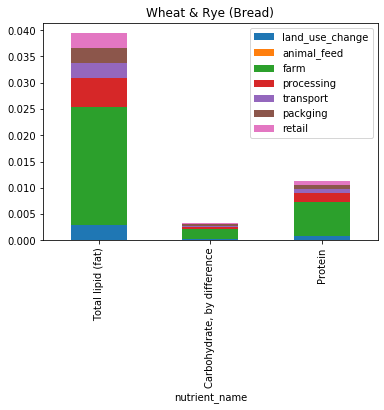

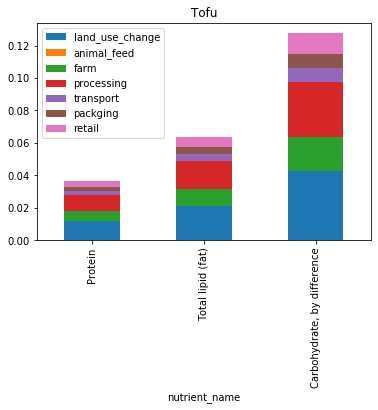

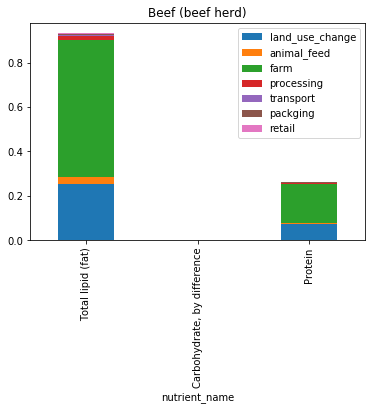

In [292]:
for food in foods:
    to_plot = food.denormalized[['nutrient_name', 'land_use_change','animal_feed','farm','processing','transport', 'packging', 'retail']]
    
    to_plot = to_plot.set_index('nutrient_name')
    to_plot.plot.bar(stacked=True, title=food.name,)